## Basic library to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy import optimize
from scipy import special

from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

## Specific library to import

In [2]:
import discretize
import empymod
from geoana.em.tdem import ElectricDipoleWholeSpace
from geoana.utils import ndgrid
from geoana.plotting_utils import plot2Ddata

## Forward modelling test: Comparison between empymod and analytic solution

In [3]:
def tem_edp_whl(sigma,t,mu,rec):
    """
    # whole space, transient, E-dipole. 
    # E-dipole is in x direction
    """
    θ = np.sqrt((mu*sigma)/(4*t))
    r = np.linalg.norm(rec,2)

    h= np.zeros((np.shape(t)[0],3))
    hamp = 2/np.sqrt(np.pi)*θ*r*np.exp(-(r**2)*(θ**2)) + special.erfc(θ*r)
    hamp = 1-hamp
    hamp /= (4*np.pi*(r**2))
    h[:,1] = -rec[2]/r*hamp
    h[:,2] = -rec[1]/r*hamp
    
    dhdt= np.zeros((np.shape(t)[0],3))
    dhamp = (θ**3)*r/(2*t*np.pi**1.5)*np.exp(-(θ**2)*(r**2))
    dhdt[:,1] = -rec[2]/r*dhamp
    dhdt[:,2] = -rec[1]/r*dhamp
    return h,dhdt


Prepare homogeneous model with conductivity of 3.0 S/m

In [4]:
res_air = 1e-14
res_sea = 1/3
res_seafloor = 1/3
res_model = 1/3
nlayers = 1

layer_thicknesses = 50.
#seabed_depth = 1004
seabed_depth = 1000.1
depth = np.hstack([np.r_[0],seabed_depth+layer_thicknesses * np.arange(nlayers+1)])
res = np.array([res_air,res_sea,res_model,res_seafloor])

Use 1.75 m as distance between receiver and dipole  
3.5m rectangular loop which is inspired by JOGMEC survey  
K.Nakayama(2019)  


In [5]:
src1 = np.r_[0. , 0. ,1000]
rec1 = np.r_[1.75 , 0., 1000]

In this case I set time range much wider so that we can see whole debay curve in b field

In [6]:
t = np.logspace(-7,-2,51)
tstrt = 1e-6
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]

Let's set transmitter as E-dipole so we can prepare with analytical result  

In [7]:

model_base = {
    'src':  src1,
    'rec':   rec1,
    'depth': depth,
    'res': res,
    'freqtime': t,
    'signal': -1,
    'verb': 0,
    'ab': 62
#    'ab': 66
}

empymod_b= -mu_0*empymod.dipole(**model_base)

model_base = {
    'src':  src1,
    'rec':   rec1,
    'depth': depth,
    'res': res,
    'freqtime': t,
    'signal': 0,
    'verb': 0,
    'ab': 62
#    'ab': 66
}

empymod_dbdt= -mu_0*empymod.dipole(**model_base)


E-dipole analytial solution

In [8]:
tem_edp_whl?

Signature: tem_edp_whl(sigma, t, mu, rec)
Docstring:
# whole space, transient, E-dipole. 
# E-dipole is in x direction
File:      c:\users\81805\appdata\local\temp\ipykernel_9784\560430804.py
Type:      function

In [9]:
rec2 = np.r_[0, -1.75, 0.]
sigma = 1/res_sea
hohmann_b_tmp, hohmann_dbdt_tmp = tem_edp_whl(sigma,t,mu_0, rec2)
hohmann_b = mu_0*hohmann_b_tmp[:,2]
hohmann_dbdt  = mu_0*hohmann_dbdt_tmp[:,2]

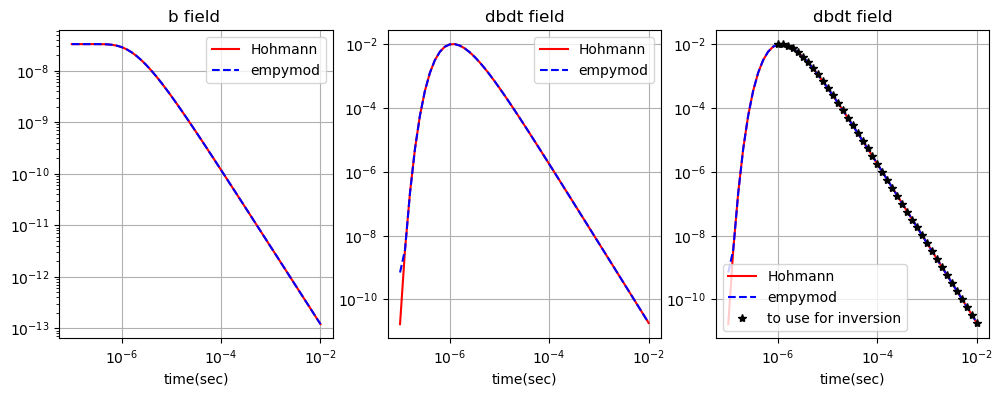

In [10]:
fig ,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].loglog(t, hohmann_b,"r-",label="Hohmann")
ax[0].loglog(t ,empymod_b,"b--",label="empymod")
ax[0].set_title("b field ")

ax[1].loglog(t, hohmann_dbdt,"r-",label="Hohmann")
ax[1].loglog(t, empymod_dbdt,"b--",label="empymod")
ax[1].set_title("dbdt field")


ax[2].loglog(t, hohmann_dbdt,"r-",label="Hohmann")
ax[2].loglog(t, empymod_dbdt,"b--",label="empymod")
ax[2].loglog(t[tindex], empymod_dbdt[tindex],"k*",label="to use for inversion")
ax[2].set_title("dbdt field")

for a in ax :
    a.grid()
    a.legend()
    a.set_xlabel("time(sec)")


Now let us see what happes when we use narrow time range as actual survey

In [11]:
t = np.logspace(-4,-2, 21)
tstrt = 1e-4
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]

In [12]:

model_base = {
    'src':  src1,
    'rec':   rec1,
    'depth': depth,
    'res': res,
    'freqtime': t,
    'signal': -1,
    'verb': 0,
    'ab': 62
}

empymod_b= -mu_0*empymod.dipole(**model_base)

model_base = {
    'src':  src1,
    'rec':   rec1,
    'depth': depth,
    'res': res,
    'freqtime': t,
    'signal': 0,
    'verb': 0,
    'ab': 62
}

empymod_dbdt= -mu_0*empymod.dipole(**model_base)


In [13]:
hohmann_b_tmp, hohmann_dbdt_tmp = tem_edp_whl(sigma,t,mu_0, rec2)
hohmann_b = mu_0*hohmann_b_tmp[:,2]
hohmann_dbdt  = mu_0*hohmann_dbdt_tmp[:,2]

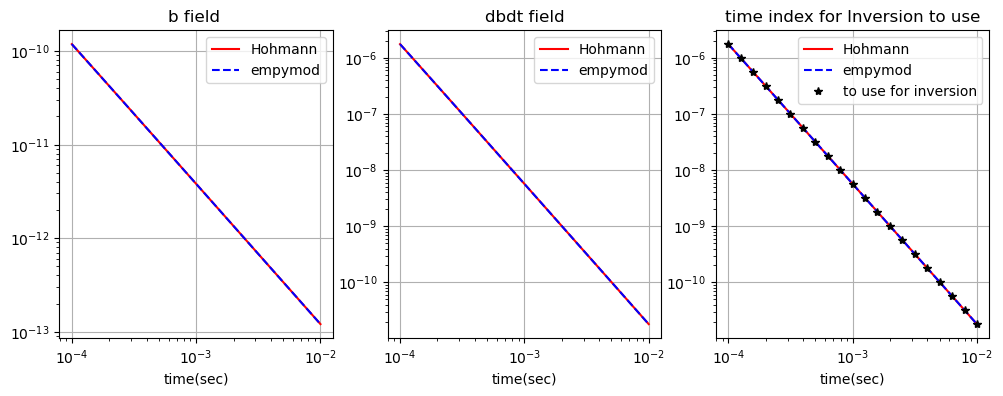

In [14]:
fig ,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].loglog(t, hohmann_b,"r-",label="Hohmann")
ax[0].loglog(t ,empymod_b,"b--",label="empymod")
ax[0].set_title("b field ")

ax[1].loglog(t, hohmann_dbdt,"r-",label="Hohmann")
ax[1].loglog(t, empymod_dbdt,"b--",label="empymod")
ax[1].set_title("dbdt field")


ax[2].loglog(t, hohmann_dbdt,"r-",label="Hohmann")
ax[2].loglog(t, empymod_dbdt,"b--",label="empymod")
ax[2].loglog(t[tindex], empymod_dbdt[tindex],"k*",label="to use for inversion")
ax[2].set_title("time index for Inversion to use")

for a in ax :
    a.grid()
    a.legend()
    a.set_xlabel("time(sec)")


## Geoana check

In [15]:
def tem_edp_whl_on(sigma,t,mu,rec):
    """
    This is function with stepon and using error function for 
    erf insted of erfc.   
    I suspect samething is implemented
    """
    θ = np.sqrt((mu*sigma)/(4*t))
    r = np.linalg.norm(rec,2)

    h= np.zeros((np.shape(t)[0],3))
    hamp = 2/np.sqrt(np.pi)*θ*r*np.exp(-(r**2)*(θ**2)) + special.erf(θ*r)
    hamp /= (4*np.pi*(r**2))
    h[:,1] = -rec[2]/r*hamp
    h[:,2] = -rec[1]/r*hamp
    
    dhdt= np.zeros((np.shape(t)[0],3))
    dhamp = (θ**3)*r/(2*(np.pi**1.5)*t)*np.exp(-(θ**2)*(r**2))
    dhdt[:,1] = -rec[2]/r*dhamp
    dhdt[:,2] = -rec[1]/r*dhamp
    return h,dhdt


In [16]:
t = np.logspace(-7,-2, 21)
tstrt = 1e-6
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]

In [17]:

model_base = {
    'src':  src1,
    'rec':   rec1,
    'depth': depth,
    'res': res,
    'freqtime': t,
    'signal': -1,
    'verb': 0,
    'ab': 62
}

empymod_b= -mu_0*empymod.dipole(**model_base)

model_base = {
    'src':  src1,
    'rec':   rec1,
    'depth': depth,
    'res': res,
    'freqtime': t,
    'signal': 0,
    'verb': 0,
    'ab': 62
}

empymod_dbdt= -mu_0*empymod.dipole(**model_base)


In [18]:
location = np.r_[0.,0.,0.]
orientation = np.r_[1., 0., 0.]
current = 1.
sigma = 1/res_sea
simulation = ElectricDipoleWholeSpace(
    time=t, location=location, orientation=orientation,
    current=current, sigma=sigma,mu=mu_0
)
xyz = ndgrid(np.r_[0.0], np.r_[-1.75], np.r_[0.0])
#xyz = ndgrid(np.linspace(-10, 10, 20), np.linspace(-10, 10, 20), np.array([0]))
geoana_b    = -simulation.magnetic_flux_density(xyz)[:,2]
geoana_dbdt = -simulation.magnetic_flux_density_time_deriv(xyz)[:,2]

In [19]:
rec2 = np.r_[0, -1.75, 0.]
sigma = 1/res_sea
hohmann_b_tmp, hohmann_dbdt_tmp = tem_edp_whl_on(sigma,t,mu_0, rec2)
hohmann_b = mu_0*hohmann_b_tmp[:,2]
hohmann_dbdt  = mu_0*hohmann_dbdt_tmp[:,2]

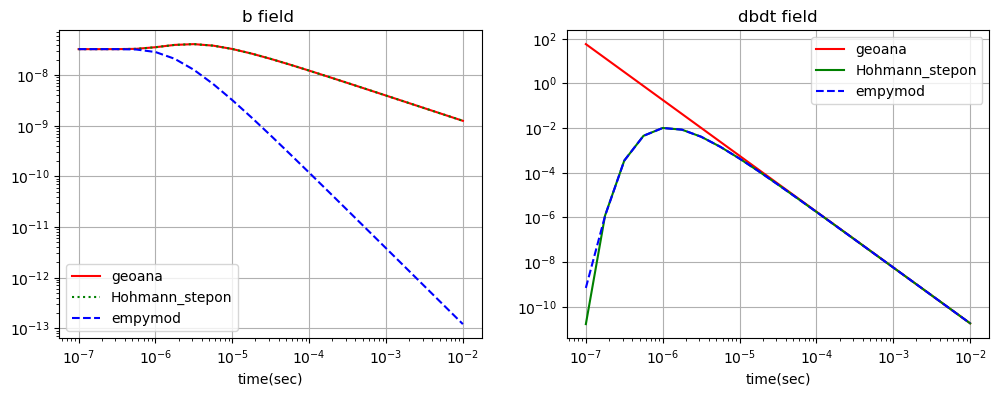

In [20]:
fig ,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].loglog(t, geoana_b,"r-",label="geoana")
ax[0].loglog(t, hohmann_b,"g:",label="Hohmann_stepon")
ax[0].loglog(t ,empymod_b,"b--",label="empymod")
ax[0].set_title("b field ")

ax[1].loglog(t, geoana_dbdt,"r-",label="geoana")
ax[1].loglog(t, hohmann_dbdt,"g-",label="Hohmann_stepon")
ax[1].loglog(t, empymod_dbdt,"b--",label="empymod")
ax[1].set_title("dbdt field")

for a in ax :
    a.grid()
    a.legend()
    a.set_xlabel("time(sec)")


In [21]:
def tem_lsc_whl(sigma,t,mu, rec):
    """
    # whole space, transient, line-source. 
    # current source in y direction
    """
    θ = np.sqrt((mu*sigma)/(4*t))
    ρ = np.sqrt(rec[0]**2 + rec[2]**2)
    h= np.zeros((np.shape(t)[0],3))
    dhdt= np.zeros((np.shape(t)[0],3))
    hamp = 1.0/(2.*np.pi*ρ)*np.exp(-(θ**2)*(ρ**2)) 
    h[:,0] = rec[2]/ρ*hamp
    h[:,2] = -rec[0]/ρ*hamp
    dhamp = ρ*(θ**2)/(2.*np.pi*t)*np.exp(-(θ**2)*(ρ**2))
    dhdt[:,0] = rec[2]/ρ*dhamp
    dhdt[:,2] = -rec[0]/ρ*dhamp
    return h,dhdt


In [22]:
def tem_mdp_whl(sigma,t,mu, rec, m=1.0):
    """
    # whole space, transient, magnetic dipole. 
    # Dipole is in the x direction
    """
    θ = np.sqrt((mu*sigma)/(4*t))
    r = np.linalg.norm(rec,2)
    h= np.zeros((np.shape(t)[0],3))
    dhdt= np.zeros((np.shape(t)[0],3))
    hamp1 = ( ( 4*(θ**3)*(r**3)/np.sqrt(np.pi) + 6*θ*r/np.sqrt(np.pi)  )*np.exp(-(θ**2)*(r**2)) + 3*special.erfc(θ*r) )
    hamp2 = ( ( 4*(θ**3)*(r**3)/np.sqrt(np.pi) + 2*θ*r/np.sqrt(np.pi)  )*np.exp(-(θ**2)*(r**2)) +   special.erfc(θ*r) )
    h[:,0] =m/(4*np.pi*r**3)*( hamp1*(rec[0]**2)/(r**2) -hamp2 ) 
    h[:,1] =m/(4*np.pi*r**3)*(rec[0]*rec[1])/(r**2)*(hamp1 ) 
    h[:,2] =m/(4*np.pi*r**3)*(rec[2]*rec[2])/(r**2)*(hamp1 ) 
    dhamp = m*θ**3/(t*np.pi**1.5)*np.exp(-(θ**2)*(r**2))
    dhdt[:,0] =dhamp*( (θ**2)*(rec[0]**2) +(1-(θ**2)*(r**2)) ) 
    dhdt[:,1] =dhamp*( (θ**2)*(rec[0]*rec[1])  ) 
    dhdt[:,2] =dhamp*( (θ**2)*(rec[0]*rec[2])  ) 
    return h,dhdt
